# Tutorial 6.3: Frequency of an Excitatory-Inhibitory Coupled Unit Oscillator and PING
### Neuroscience goal
- discover how the frequency and amplitude of oscillations in a circuit can depend on external inputs
### Computational goal
- addressing limiting cases of "0/0" analytically
- introduction to Fourier transform

### Overview
- will simulate the circuit of an excitatory firing-rate unit (1) coupled to an inhibitory firing-rate unit (2) with parameters leading to oscillations
- will measure amplitude and frequency of oscillations and in so doing will see how a Fourier transform operates

firing rate function for each unit will be based on the empirical fit (Chance & Abbott) to response of LIF neurons:

$f(V_{ss}) = \frac{V_{ss} - V_{th}}{\tau(V_{th}-V_{reset})[1 - exp[-(V_{ss} - V_{th}) / \sigma _v]]}$

in this model, $V_{ss}$ is the steady state membrane potential of the LIF model in the absence of spiking:

$V_{ss} = \frac{G_LE_L + G_IE_I + G_EE_E}{G_L + G_I + G_E}$

where $G_L, G_I, G_E$ are respectively, leak, inhibitory, excitatory conductances (which can vary with time)

and $E_L, E_I, E_E$ are their corresponding fixed reversal potentials

$V_{th}$  is the threshold of the membrane potential

$V_{reset}$ is the reset potential

$\tau$ is the membrane time constant

$\sigma _v$ is the noise parameter in the membrane potential, determines the steepness and sharpness of curvature of the firing-rate curve



- as written, the function $f(V_{ss})$ is undefined if $V_{ss} = V_{th}$ (both numerator and denominator are 0)
    - however, one can show that in the limit of very small $\delta$ (if $\delta << \sigma _v$), if $V_{ss} = V_{th} + \delta$ or $V_{ss} = V_{th} - \delta$, then
    $f(V_{ss}) \sim \sigma _v / [\tau(V_{ss} - V_{reset})]$

- therefore, the function $f(V_{ss})$ should be defined to having this limiting value when $\delta$ = 0 (and $V_{ss} = V_{th}$) 
- the computer cannot figure out such a limit though, so when evaluating the function, must include a conditional statement in the code to produce the correct limiting value instead of dividing by zero

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# parameters
v_thresh = -50e-3
v_reset = -80e-3
sigma_v = 1e-3
tau = 3e-3
e_leak = -70e-3
e_inhibitory = -65e-3
e_excitatory = 0e-3
g_leak = 50e-12

# connection strengths
w_ee = 25e-9
w_ei = 4e-9
w_ie = 800e-9

In [4]:
# excitatory and inhibitory conductances, vary by time

excitatory and inhibitory conductances, G_E and G_I

$ G_E^{(1)}(t) = W^{EE}s^{(1)}_E(t) + G_{in}^{(1)} $

$ G_I^{(1)}(t) = W^{IE}s^{(2)}_I(t) $

$ G_E^{(2)}(t) = W^{EI}s^{(1)}_E(t) + G_{in}^{(2)}$

$ G_I^{(2)}(t) = 0$

In [3]:
# excitatory input conductances will vary across trials
# initialize at:
g1_in = 1e-9
g2_in = 0e-9

# 1. simulate two units
- set up the simulation of two units with parameters given, such that for unit *i*, firing rate varies according to:

$ \tau \frac{dr_i}{dt} = -r_i + f(V_{ss,i})$

where $V_{ss, i}$ is the instantaneous steady state that depends on the values of conductances for unit *i* as described above

the synaptic variables depend on presynaptic rate according to:

$ \frac{ds_E^{(1)}}{dt} = -\frac{s_E^{(1)}}{\tau _E} + \alpha r_1 (1 - s_E^{(1)})$

and 

$ \frac{ds_E^{(1)}}{dt} = -\frac{s_E^{(1)}}{\tau _E} + \alpha r_1 (1 - s_E^{(1)})$

In [69]:
tau_e = 2e-3
tau_i = 5e-3
alpha = 0.2
tmax = 2.5
dt = 0.1e-3

t = np.arange(0, tmax, dt)

In [70]:
# set up firing rate equation (f(V_ss))
def firing_rate_function(v_ss, v_thresh, v_reset, tau, sigma_v):
    if v_ss == v_thresh:
        return sigma_v / (tau * (v_ss - v_reset))
    else:
        return (v_ss - v_thresh) / (tau * (v_thresh - v_reset) * (1 - np.exp(-(v_ss - v_thresh) / sigma_v)))
    
# set up v_ss equation
def get_v_ss(g_leak, e_leak, G_E, e_excitatory, G_I, e_inhibitory):
    return (g_leak * e_leak + G_E * e_excitatory + G_I * e_inhibitory)/(g_leak + G_E + G_I)

# set up unit simulation
def simulate(tmax, dt, g_leak, e_leak, e_excitatory, e_inhibitory, v_thresh,v_reset, tau, sigma_v, tau_e, tau_i, alpha, initial_conditions=None):
    t = np.arange(0, tmax, dt)

    # initialize firing rate and synaptic variables
    r1 = np.zeros_like(t)
    r2 = np.zeros_like(t)
    s_e1 = np.zeros_like(t)
    s_i2 = np.zeros_like(t)
    g_e1 = np.zeros_like(t)
    g_e2 = np.zeros_like(t)
    g_i1 = np.zeros_like(t)

    for i, t in enumerate(t[:-1]):
        # update conductances
        g_e1[i] = w_ee * s_e1[i] + g1_in
        g_i1[i] = w_ie * s_i2[i]
        g_e2[i] = w_ei * s_e1[i] + g2_in

        # v_ss for each unit
        v_ss1 = get_v_ss(g_leak, e_leak, g_e1[i], e_excitatory, g_i1[i], e_inhibitory)
        v_ss2 = get_v_ss(g_leak, e_leak, g_e2[i], e_excitatory, 0, e_inhibitory)

        # firing rate over time for each unit
        dr1_dt = (-r1[i] + firing_rate_function(v_ss1, v_thresh, v_reset, tau, sigma_v)) / tau
        dr2_dt = (-r2[i] + firing_rate_function(v_ss2, v_thresh, v_reset, tau, sigma_v)) / tau
        # and update
        r1[i+1] = r1[i] + dr1_dt*dt
        r2[i+1] = r2[i] + dr2_dt*dt

        # calculate synaptic variables
        ds_e1_dt = (-s_e1[i] / tau_e) + alpha * r1[i] * (1 - s_e1[i])
        ds_i1_dt = (-s_i2[i] / tau_i) + alpha * r2[i] * (1 - s_i2[i])
        # and update
        s_e1[i+1] = s_e1[i] + ds_e1_dt*dt
        s_i2[i+1] = s_i2[i] + ds_i1_dt*dt




    return r1, r2

In [71]:
r1, r2 = simulate(tmax, dt, g_leak, e_leak, e_excitatory, e_inhibitory, v_thresh, v_reset, tau, sigma_v, tau_e, tau_i, alpha)

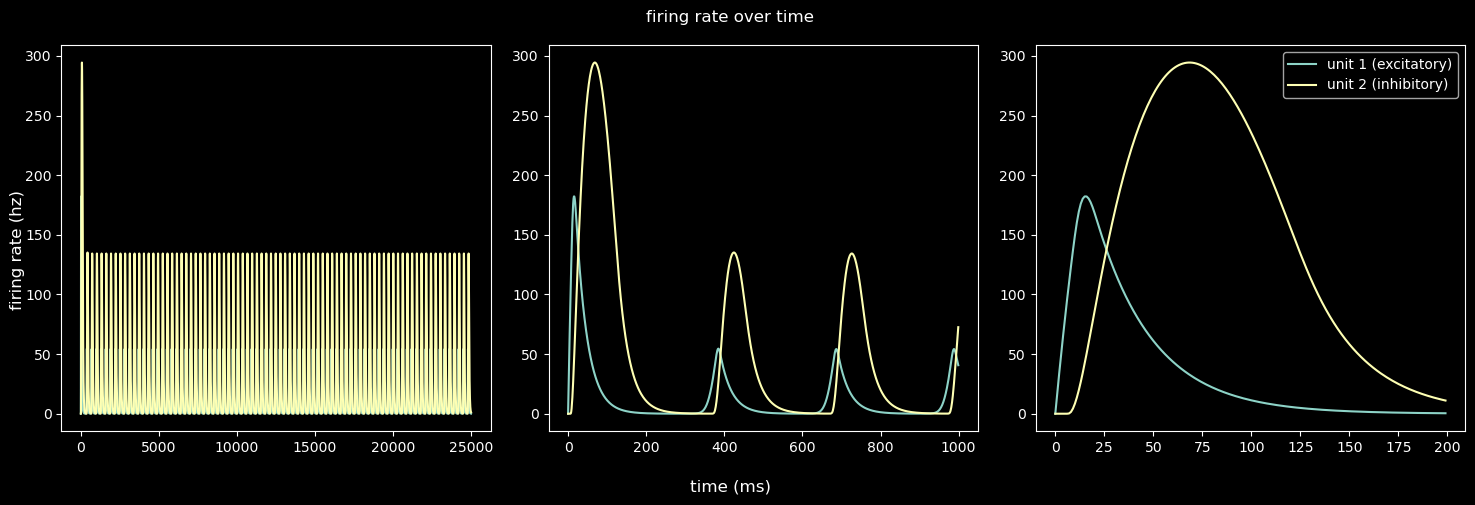

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(r1, label='unit 1 (excitatory)')
ax[0].plot(r2, label='unit 2 (inhibitory)')

ax[1].plot(r1[:1000], label='unit 1 (excitatory)')
ax[1].plot(r2[:1000], label='unit 2 (inhibitory)')

ax[2].plot(r1[:200], label='unit 1 (excitatory)')
ax[2].plot(r2[:200], label='unit 2 (inhibitory)')

fig.suptitle('firing rate over time')
fig.supxlabel('time (ms)')
fig.supylabel('firing rate (hz)')
plt.legend()
plt.tight_layout()

# 2. calculate oscillation frequency

In [81]:
# a. 
# copy firing rate of first unit into new vector, omitting initial transient unstable period
r1_stable = r1[1000:]

# b.
# determine max and min values of firing rate during oscillation and use values to select two thresholds
# one a little below max rate to indicate the rate is approaching a peak 
# one a little above min rate to indicate the rate is approaching a trough
r1_max = r1_stable.max()
r1_min = r1_stable.min()
r1_high_thresh = r1_max - 1
r1_low_thresh = r1_min + 1

# c. 
# define a threshold-crossing indicator, initialized with a value of 0

thresh_cross = 1 if r1_stable[0] > r1_high_thresh else 0


# d. 
# loop through vector, set conditional such that if thresh_cross is 0 and rate is greater than thresh:
# time point is recorded and thresh_cross is set to 1
# if rate is lower than lower threshold, reset thresh_cross to 0
time_points = []
for i in range(len(r1_stable)):
    if thresh_cross == 0:
        if r1_stable[i] > r1_high_thresh:
            thresh_cross = 1
            time_points.append(i)
    elif r1_stable[i] < r1_low_thresh:
        thresh_cross = 0

# e. calculate oscillation period using times of first and last crossings of higher threshold
time_points = np.asarray(time_points)
first = time_points[0]
last = time_points[-1]
period = last - first

frequency = len(time_points) / period
print('frequency: ', frequency)
print('frequency * 1000:', frequency * 10000)


frequency:  0.0033598434908348575
frequency * 1000: 33.59843490834857


# 3. Fourier transform

In [76]:
# a. 
# truncate firing rate vector as in 2a
r1_stable = r1[1000:]

# b.
# produce vector of frequency values from 0 Hz to 100 Hz, with steps of 0.2 Hz, and set up a loop through all values of the vector
frequencies = np.arange(0, 101, 0.2)
t = np.arange(0, len(r1_stable)*dt, dt)

# lists to store coefficients 
a_list = []
b_list = [] 
for freq in frequencies:
    # c. 
    # within the loop, for each frequency, f, create two vectors, each of the same length as the truncated firing vector (r1_stable)
    # one equal to sin(2*pi*f*t), and the other equal to cos(2*pi*f*t)
    # where the time points, t, span the time interval of r1_stable vector in steps of delta_t
    sin_vector = np.ones_like(r1_stable) * np.sin(2 * np.pi * freq * t)
    cos_vector = np.ones_like(r1_stable) * np.cos(2 * np.pi * freq * t)
    
    # d. 
    # find the overlaps between the sine vector and the truncated firing rate vector
    # by multiplying each corresponding element of the two vectors and taking the mean of the result
    # record this overlap in a vector of coefficients:
    # A(f) = sin(2*pi*f*t) * r_1(t)
    # repeat to find the overlap of the firing rate vector with the cosine vector, to produce a set of coefficients:
    # B(f) = cos(2*pi*f*t) * r_1(t)

    a_coeff = np.mean(sin_vector * r1_stable)
    b_coeff = np.mean(cos_vector * r1_stable)
    a_list.append(a_coeff)
    b_list.append(b_coeff)

a_list = np.array(a_list)
b_list = np.array(b_list)



Frequency with highest power (non-zero) is 33.2


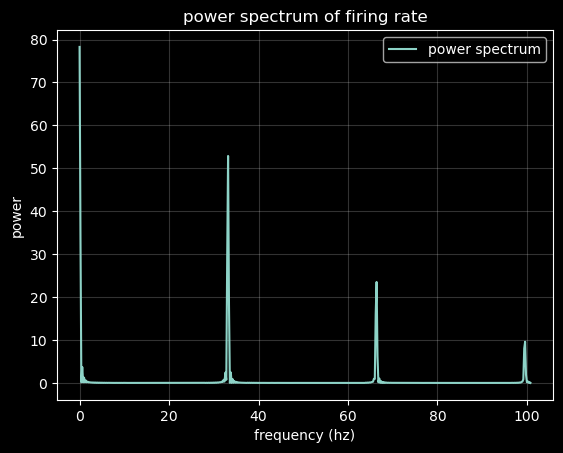

In [92]:
# e.
# you now have two vectors;
# one with coefficients that represent how similar the oscillating firing rate is to a sine wave of a given frequency
# other with similarity to cos wave
# turns out, sum of the squares of these two coefficients provides a measure of oscillating power that is independent of phase offset
# the oscillation can be a sine or a cosine or anywhere between, and the sum of squares is not altered
# produce a power spectrum as a vector such that each element, P(f), is the sum of squares of
# the corresponding sine coefficient and cosine coefficient: P(f) = A^2(f) + B^2(f)

power_spectrum = a_list**2 + b_list**2

# f. 
# plot P(f) as a function of the frequency vector and extract the value of f other than zero for which P(f) is the greatest
# compare this frequency to the oscillation frequency calculated in 2

plt.plot(frequencies[:], power_spectrum[:], label='power spectrum')
plt.xlabel('frequency (hz)')
plt.ylabel('power')
plt.title('power spectrum of firing rate')
plt.legend()
plt.grid(which='both', alpha=0.2)

max_power_index = np.argmax(power_spectrum[1:]) + 1
max_power_freq = frequencies[max_power_index]
print(f'Frequency with highest power (non-zero) is {max_power_freq}')

In [ ]:
def fourier(r1):
    # truncate
    r = r1[1000:]

    # loop through freq vals
    frequencies = np.arange(0, 101, 0.2)
    t = np.arange(0, len(r)*dt, dt)

    # lists to store coefficients 
    a_list = []
    b_list = [] 
    for freq in frequencies:
        
        sin_vector = np.ones_like(r1_stable) * np.sin(2 * np.pi * freq * t)
        cos_vector = np.ones_like(r1_stable) * np.cos(2 * np.pi * freq * t)

        a_coeff = np.mean(sin_vector * r1_stable)
        b_coeff = np.mean(cos_vector * r1_stable)
        a_list.append(a_coeff)
        b_list.append(b_coeff)

    a_list = np.array(a_list)
    b_list = np.array(b_list)


In [93]:
# answer from 2 was 0.0033, but *10000 get 33.5, which is close to this frequency
# think this is bc time step is 0.0001s

# 4. 
let applied stimulus to excitatory cells range from $G_{in}^{(1)} = 0 nS to G_{in}^{(1)} = 10 nS$ (while keeping input to inhibitory cells at 0)
plot relevant figures to determine how oscillation frequency, oscillation amplitude for both excitatory and inhibitory cells, and the mean firing rates of both excitatory and inhibitory cells depend on $G_{in}^{(1)}$

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(5, 15))

ax[0].plot()
ax[0].set_xlabel('stimulus amplitude')
ax[0].set_ylabel('oscillation frequency (hz)')

ax[1].plot()
ax[1].set_xlabel('stimulus amplitude')
ax[1].set_ylabel('oscillation amplitude')
ax[1].legend()

ax[2].plot()
ax[2].set_xlabel('stimulus amplitude')
ax[2].set_ylabel('mean firing rate (hz)')
ax[2].legend()